# 0. Introduction

This notebook is for the BraTS-2023 MICCAI challenge.
The International Brain Tumor Segmentation (BraTS) challenge. BraTS, since 2012, has focused on the generation of a benchmarking environment and dataset for the delineation of adult brain gliomas. The focus of this year’s challenge remains the generation of a common benchmarking environment, but its dataset is substantially expanded to ~4,500 cases towards addressing additional i) populations (e.g., sub-Saharan Africa patients), ii) tumors (e.g., meningioma), iii) clinical concerns (e.g., missing data), and iv) technical considerations (e.g., augmentations). Specifically, the focus of BraTS 2023 is to identify the current state-of-the-art algorithms for addressing (Task 1) the same adult glioma population as in the RSNA-ANSR-MICCAI BraTS challenge, as well as (Task 2) the underserved sub-Saharan African brain glioma patient population, (Task 3) intracranial meningioma, (Task 4) brain metastasis, (Task 5) pediatric brain tumor patients, (Task 6) global & local missing data, (Task 7) useful augmentation techniques, and importantly (Task 8) the algorithmic generalizability across Tasks 1-5. Details for each ‘Task’ are listed in the rest of this documents.

Notably, all data are routine clinically-acquired, multi-site multiparametric magnetic resonance imaging (mpMRI) scans of brain tumor patients. The BraTS 2023 challenge participants are able to obtain the training and validation data of the challenge at any point from the Synapse platform. These data will be used to develop, containerize, and evaluate their algorithms in unseen validation data until August 2023, when the organizers will stop accepting new submissions and evaluate the submitted algorithms in the hidden testing data. Ground truth reference annotations for all datasets are created and approved by expert neuroradiologists for every subject included in the training, validation, and testing datasets to quantitatively evaluate the performance of the participating algorithms.

**Challenges**
1. Segmentation - Adult Glioma
2. Segmentation - BraTS-Africa
3. Segmentation - Meningioma
4. Segmentation - Brain Metastases
5. Segmentation - Pediatric Tumors
7. Synthesis (Global) - Missing MRI
8. Synthesis (Local) - Inpainting
9. Evaluating Augmentations for BraTS


**Timeline**

<table>
  <tr>
    <th>Date</th>
    <th>Event</th>
  </tr>
  <tr>
    <td>1 May</td>
    <td>Challenge launch<br>Registration opens</td>
  </tr>
  <tr>
    <td>mid-May</td>
    <td>Release of training data with ground truth labels</td>
  </tr>
  <tr>
    <td>mid-June late June</td>
    <td>Release of validation data (without labels)<br>Validation phase opens (official start date to be announced)</td>
  </tr>
  <tr>
    <td>31 July</td>
    <td>Validation phase ends (submission deadline of segmentation files)<br>Submission deadline of short papers in CMT, reporting method and preliminary results.</td>
  </tr>
  <tr>
    <td>1 August</td>
    <td>Testing phase opens<br>(available only to participants who submitted short papers)</td>
  </tr>
  <tr>
    <td>7 August</td>
    <td>Testing phase ends (submission deadline of MLCubes)</td>
  </tr>
  <tr>
    <td>11 - 25 August</td>
    <td>Evaluation of MLCubes on testing data<br>(performed by challenge organizers)</td>
  </tr>
  <tr>
    <td>mid-September</td>
    <td>Top performing methods contacted for preparing oral presentation slides</td>
  </tr>
  <tr>
    <td>mid-October</td>
    <td>Announcement of the final top 3 ranked teams</td>
  </tr>
  <tr>
    <td>30 November</td>
    <td>Camera-ready submission of extended papers for inclusion in the associated workshop proceedings</td>
  </tr>
</table>



We'll start with the `Segmentation - Pediatric Tumors` challenge.

*Pediatric tumors of the central nervous system are the most common cause of cancer-related death in children. The five-year survival rate for high-grade gliomas in children is less than 20\%. Due to their rarity, the diagnosis of these entities is often delayed, their treatment is mainly based on historic treatment concepts, and clinical trials require multi-institutional collaborations. The MICCAI Brain Tumor Segmentation (BraTS) Challenge is a landmark community benchmark event with a successful history of 12 years of resource creation for the segmentation and analysis of adult glioma. Here we present the CBTN-CONNECT-DIPGR-ASNR-MICCAI BraTS-PEDs 2023 challenge, which represents the first BraTS challenge focused on pediatric brain tumors with data acquired across multiple international consortia dedicated to pediatric neuro-oncology and clinical trials. The BraTS-PEDs 2023 challenge focuses on benchmarking the development of volumentric segmentation algorithms for pediatric brain glioma through standardized quantitative performance evaluation metrics utilized across the BraTS 2023 cluster of challenges. Models gaining knowledge from the BraTS-PEDs multi-parametric structural MRI (mpMRI) training data will be evaluated on separate validation and unseen test mpMRI dataof high-grade pediatric glioma. The CBTN-CONNECT-DIPGR-ASNR-MICCAI BraTS-PEDs 2023 challenge brings together clinicians and AI/imaging scientists to lead to faster development of automated segmentation techniques that could benefit clinical trials, and ultimately the care of children with brain tumors.* from [The Brain Tumor Segmentation (BraTS) Challenge 2023: Focus on Pediatrics (CBTN-CONNECT-DIPGR-ASNR-MICCAI BraTS-PEDs)](https://arxiv.org/abs/2305.17033)


## 1.0. Packages, Libraries, & Configs

### 1.0.1 For UNET 2D

In [ ]:
!pip install git+https://github.com/miykael/gif_your_nifti -q # nifti to gif
!pip install -U nilearn -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.3 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import shutil
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import clear_output, Image

from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize

import gif_your_nifti.core as gif2nif

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

# ML Libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

### 1.0.2 For MONAI EXPs

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[all]"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 37.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import json
import shutil
import tempfile
import time

from IPython.display import clear_output, Image

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch

%matplotlib inline
print_config()

MONAI version: 1.3.dev2328
Numpy version: 1.22.4
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 6a85cf941ef286e967b627b6b4001df7b247f301
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 3.0.2
scikit-image version: 0.19.3
Pillow version: 8.4.0
Tensorboard version: 2.12.3
gdown version: 4.6.6
TorchVision version: 0.15.2+cu118
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.5
pandas version: 1.5.3
einops version: 0.6.1
transformers version: 4.21.3
mlflow version: 2.4.2
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
!nvidia-smi

Wed Jul 12 04:43:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 2.0 Dataset

Modality: MRI Size: 144 3D volumes (99 Training + 45 Validation)
Challenge: RSNA-ASNR-MICCAI Brain Tumor Segmentation (BraTS) Challenge PED

The dataset needs to be downloaded from the official BraTS 23 challenge portal.

In [ ]:
class configs():
  HOME = os.getcwd()

  data_root_path = os.path.join(HOME, "drive/MyDrive/Brats23")
  data_path_zip = os.path.join(data_root_path, 'ped/ASNR-MICCAI-BraTS2023-PED-Challenge-TrainingData.zip')
  data_val_path_zip = os.path.join(data_root_path, 'ped/ASNR-MICCAI-BraTS2023-PED-Challenge-ValidationData.zip')

  data_path_unzip = os.path.join(HOME, 'Brat23')
  data_dir_path = os.path.join(HOME, 'Brat23', 'ASNR-MICCAI-BraTS2023-PED-Challenge-TrainingData')
  data_val_dir_path = os.path.join(HOME, 'Brat23', 'ASNR-MICCAI-BraTS2023-PED-Challenge-ValidationData')

  datasets_path = {}
  datasets_val_path ={}

In [ ]:
# unzipping the dataset
if not os.path.exists(configs.data_path_unzip):
  !unzip $configs.data_path_zip -d $configs.data_path_unzip
  !unzip $configs.data_val_path_zip -d $configs.data_path_unzip
clear_output()

In [ ]:
# calculating train files
for dir in os.listdir(configs.data_dir_path):
  configs.datasets_path[os.path.join(configs.data_dir_path, dir)] = os.listdir(os.path.join(configs.data_dir_path, dir))

In [ ]:
# calculating val files
for dir in os.listdir(configs.data_val_dir_path):
  configs.datasets_val_path[os.path.join(configs.data_val_dir_path, dir)] = os.listdir(os.path.join(configs.data_val_dir_path, dir))

In [ ]:
print(f"Total PED Train files: {len(configs.datasets_path)}")
print(f"Total PED Val files: {len(configs.datasets_val_path)}")

print(f"First PED filename: {list(configs.datasets_path.items())[0][0]}")
print(f"First PED files: {list(configs.datasets_path.items())[0][1]}")

Total PED Train files: 99
Total PED Val files: 45
First PED filename: /content/Brat23/ASNR-MICCAI-BraTS2023-PED-Challenge-TrainingData/BraTS-PED-00097-000
First PED files: ['BraTS-PED-00097-000-t1n.nii.gz', 'BraTS-PED-00097-000-seg.nii.gz', 'BraTS-PED-00097-000-t2f.nii.gz', 'BraTS-PED-00097-000-t1c.nii.gz', 'BraTS-PED-00097-000-t2w.nii.gz']


### 2.1. NIFTI file details

* 'BraTS-PED-00104-000-t1n.nii.gz': This file contains a volume of brain images acquired using the `T1-weighted modality after contrast` administration with gadolinium. T1-weighted images provide anatomical information about brain tissues.

* 'BraTS-PED-00104-000-t2f.nii.gz': This file contains a volume of brain images acquired using the T2-weighted Fluid-Attenuated Inversion Recovery (FLAIR) modality. `T2-FLAIR` images are sensitive to abnormalities like edema and can help in identifying tumor regions.

* 'BraTS-PED-00104-000-t1c.nii.gz': This file contains a volume of brain images acquired using the T1-weighted modality after contrast administration with gadolinium. `T1-weighted post-contrast` images help highlight areas of increased vascular permeability, such as active tumor regions.

* 'BraTS-PED-00104-000-t2w.nii.gz': This file contains a volume of brain images acquired using the T2-weighted modality. `T2-weighted` images provide information about brain tissue contrast and can help in detecting abnormalities.

* 'BraTS-PED-00104-000-seg.nii.gz': This file contains the `segmentation map` or label map for the corresponding patient's brain tumor. Each voxel in this image is labeled to indicate different regions, such as tumor core, peritumoral edema, and enhancing tumor regions.

### 2.2. Single Example

In [ ]:
image_no = 1

In [ ]:
example_1_path = list(configs.datasets_path.items())[image_no][0]
example_1_files = list(configs.datasets_path.items())[image_no][1]
sorted(example_1_files)

['BraTS-PED-00061-000-seg.nii.gz',
 'BraTS-PED-00061-000-t1c.nii.gz',
 'BraTS-PED-00061-000-t1n.nii.gz',
 'BraTS-PED-00061-000-t2f.nii.gz',
 'BraTS-PED-00061-000-t2w.nii.gz']

In [ ]:

test_image_T2f = nib.load(os.path.join(example_1_path, sorted(example_1_files)[3])).get_fdata()
test_image_T1n = nib.load(os.path.join(example_1_path, sorted(example_1_files)[2])).get_fdata()
test_image_T1c = nib.load(os.path.join(example_1_path, sorted(example_1_files)[1])).get_fdata()
test_image_T2w = nib.load(os.path.join(example_1_path, sorted(example_1_files)[4])).get_fdata()
test_image_seg = nib.load(os.path.join(example_1_path, sorted(example_1_files)[0])).get_fdata()


In [ ]:
print(f"Shape of T2 Flair is: {test_image_T2f.shape}")

Shape of T2 Flair is: (240, 240, 155)


In [ ]:
print(f"Shape of Mask is: {test_image_seg.shape}")

Shape of Mask is: (240, 240, 155)


In [ ]:
large_seg_map = np.array([cv2.countNonZero(test_image_seg[:, :, i]) for i in range(test_image_seg.shape[2])])
slice = np.where(large_seg_map == large_seg_map.max())[0][0]

Text(0.5, 1.0, 'Mask')

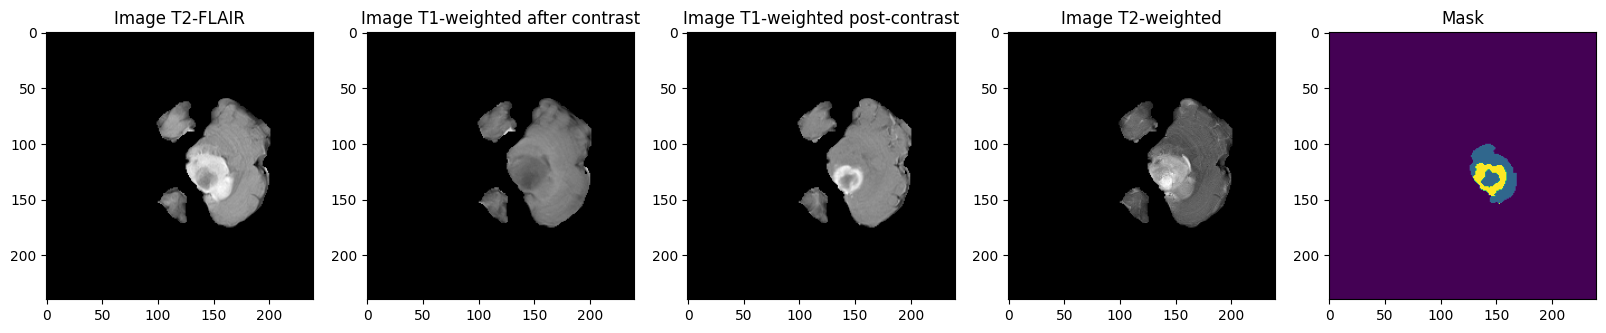

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))

ax1.imshow(test_image_T2f[:,:,slice], cmap = 'gray')
ax1.set_title('Image T2-FLAIR')
ax2.imshow(test_image_T1n[:,:,slice], cmap = 'gray')
ax2.set_title('Image T1-weighted after contrast')
ax3.imshow(test_image_T1c[:,:,slice], cmap = 'gray')
ax3.set_title('Image T1-weighted post-contrast')
ax4.imshow(test_image_T2w[:,:,slice], cmap = 'gray')
ax4.set_title('Image T2-weighted')
ax5.imshow(test_image_seg[:,:,slice])
ax5.set_title('Mask')

Text(0.5, 1.0, 'Segittal')

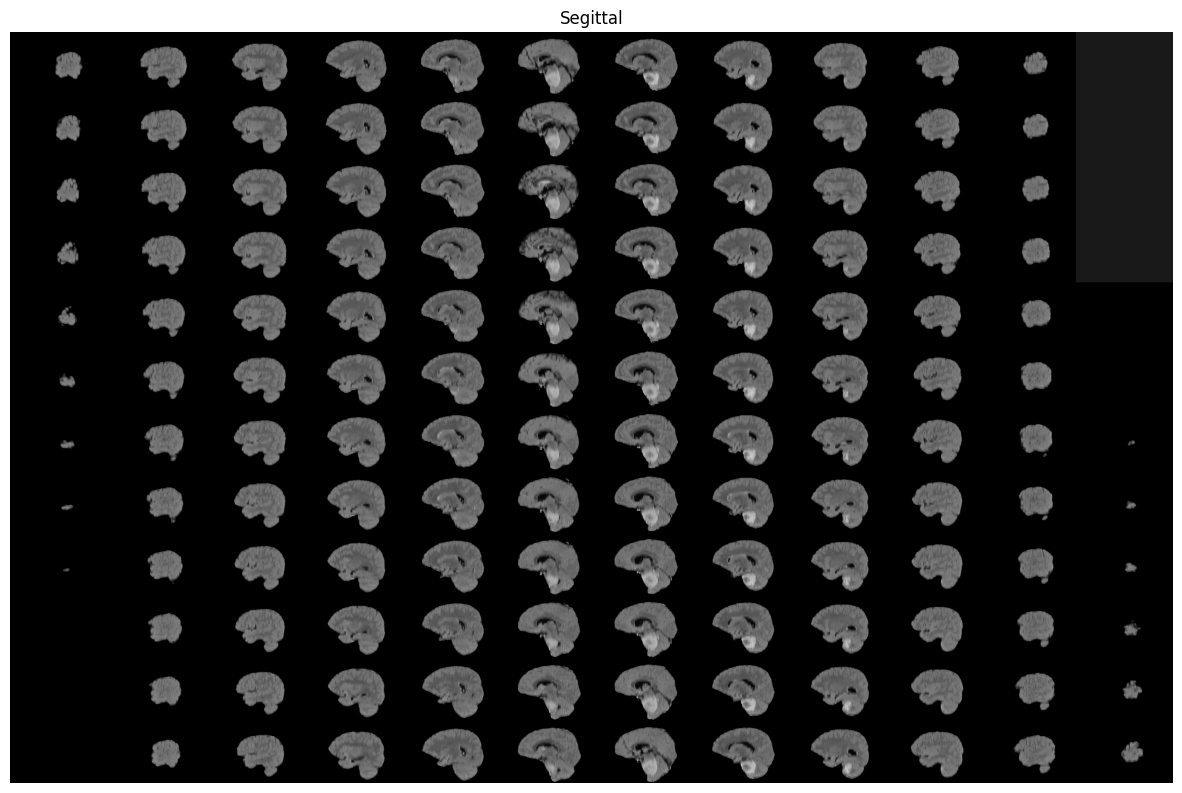

In [ ]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_T2f[50:-50,:,:]), 90, resize=True), cmap ='gray')
ax1.axis(False)
ax1.set_title('Segittal')

Text(0.5, 1.0, 'Segittal')

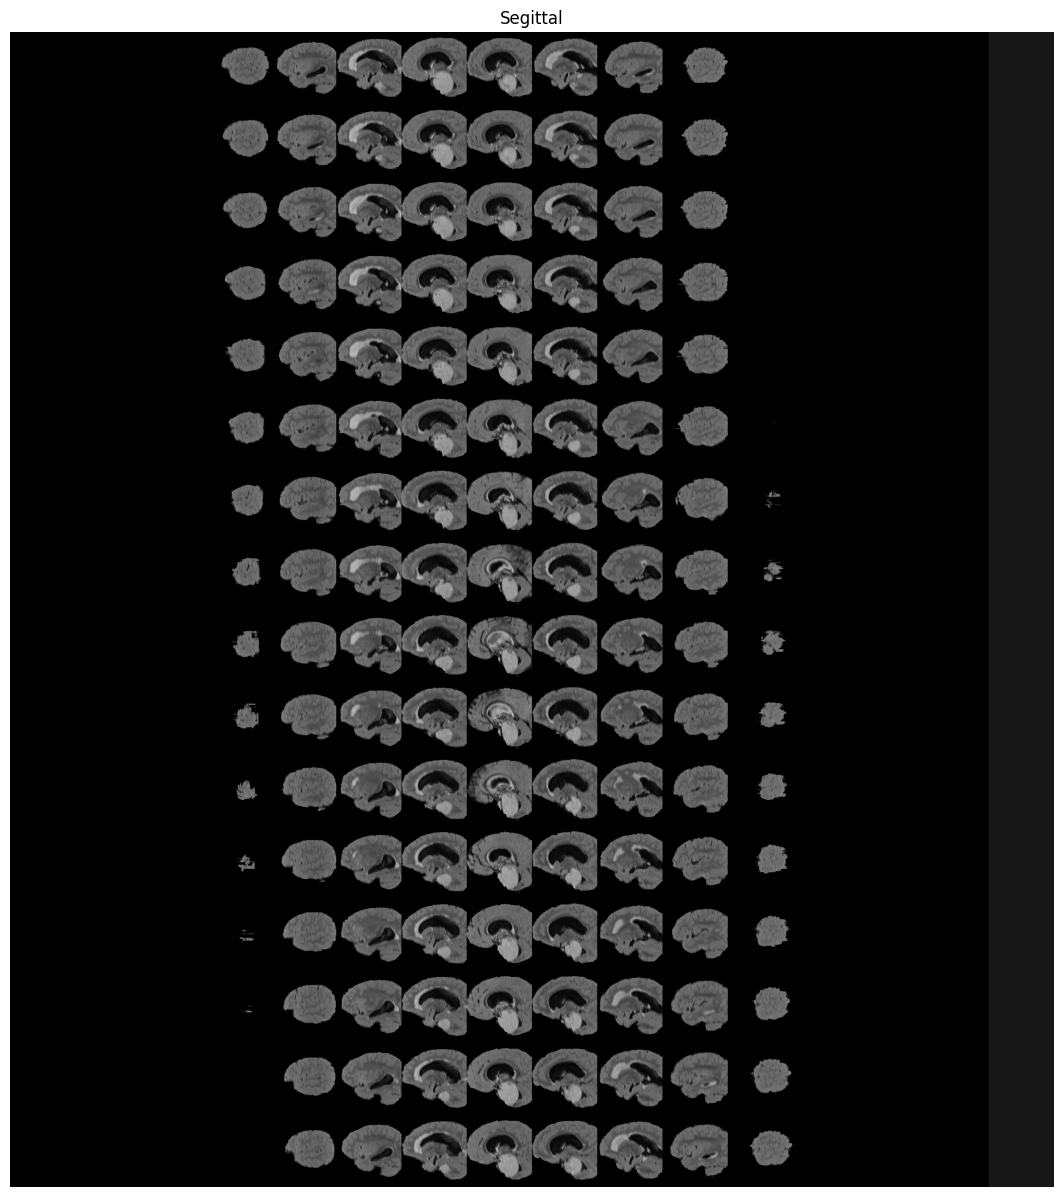

In [ ]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_T2f[:,50:-50,:]), 90, resize=True), cmap ='gray')
ax1.axis(False)
ax1.set_title('Segittal')

In [ ]:
print("Segmentation mask unique values or classes:",np.unique(test_image_seg[test_image_seg!=0.0]))

Segmentation mask unique values or classes: [1. 2. 3.]


Text(0.5, 1.0, 'Mask')

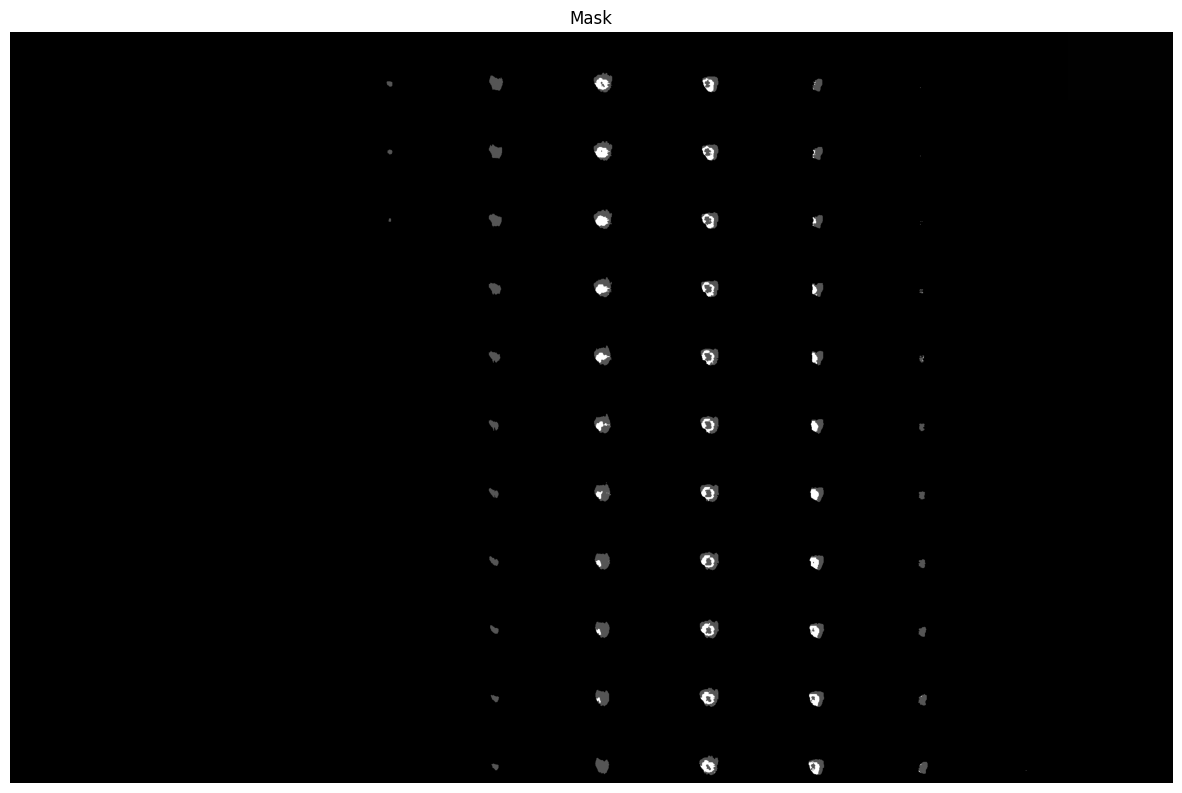

In [ ]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_seg[60:-60,:,:]), 90, resize=True), cmap ='gray')
ax1.axis(False)
ax1.set_title('Mask')

In [ ]:
path_gif = 'test_gif_BraTS23_flair.gif'
shutil.copy2(os.path.join(example_1_path, sorted(example_1_files)[3]), './test_gif_BraTS23_flair.nii.gz')
gif2nif.write_gif_normal('./test_gif_BraTS23_flair.nii.gz')
clear_output()

In [ ]:
Image(path_gif)

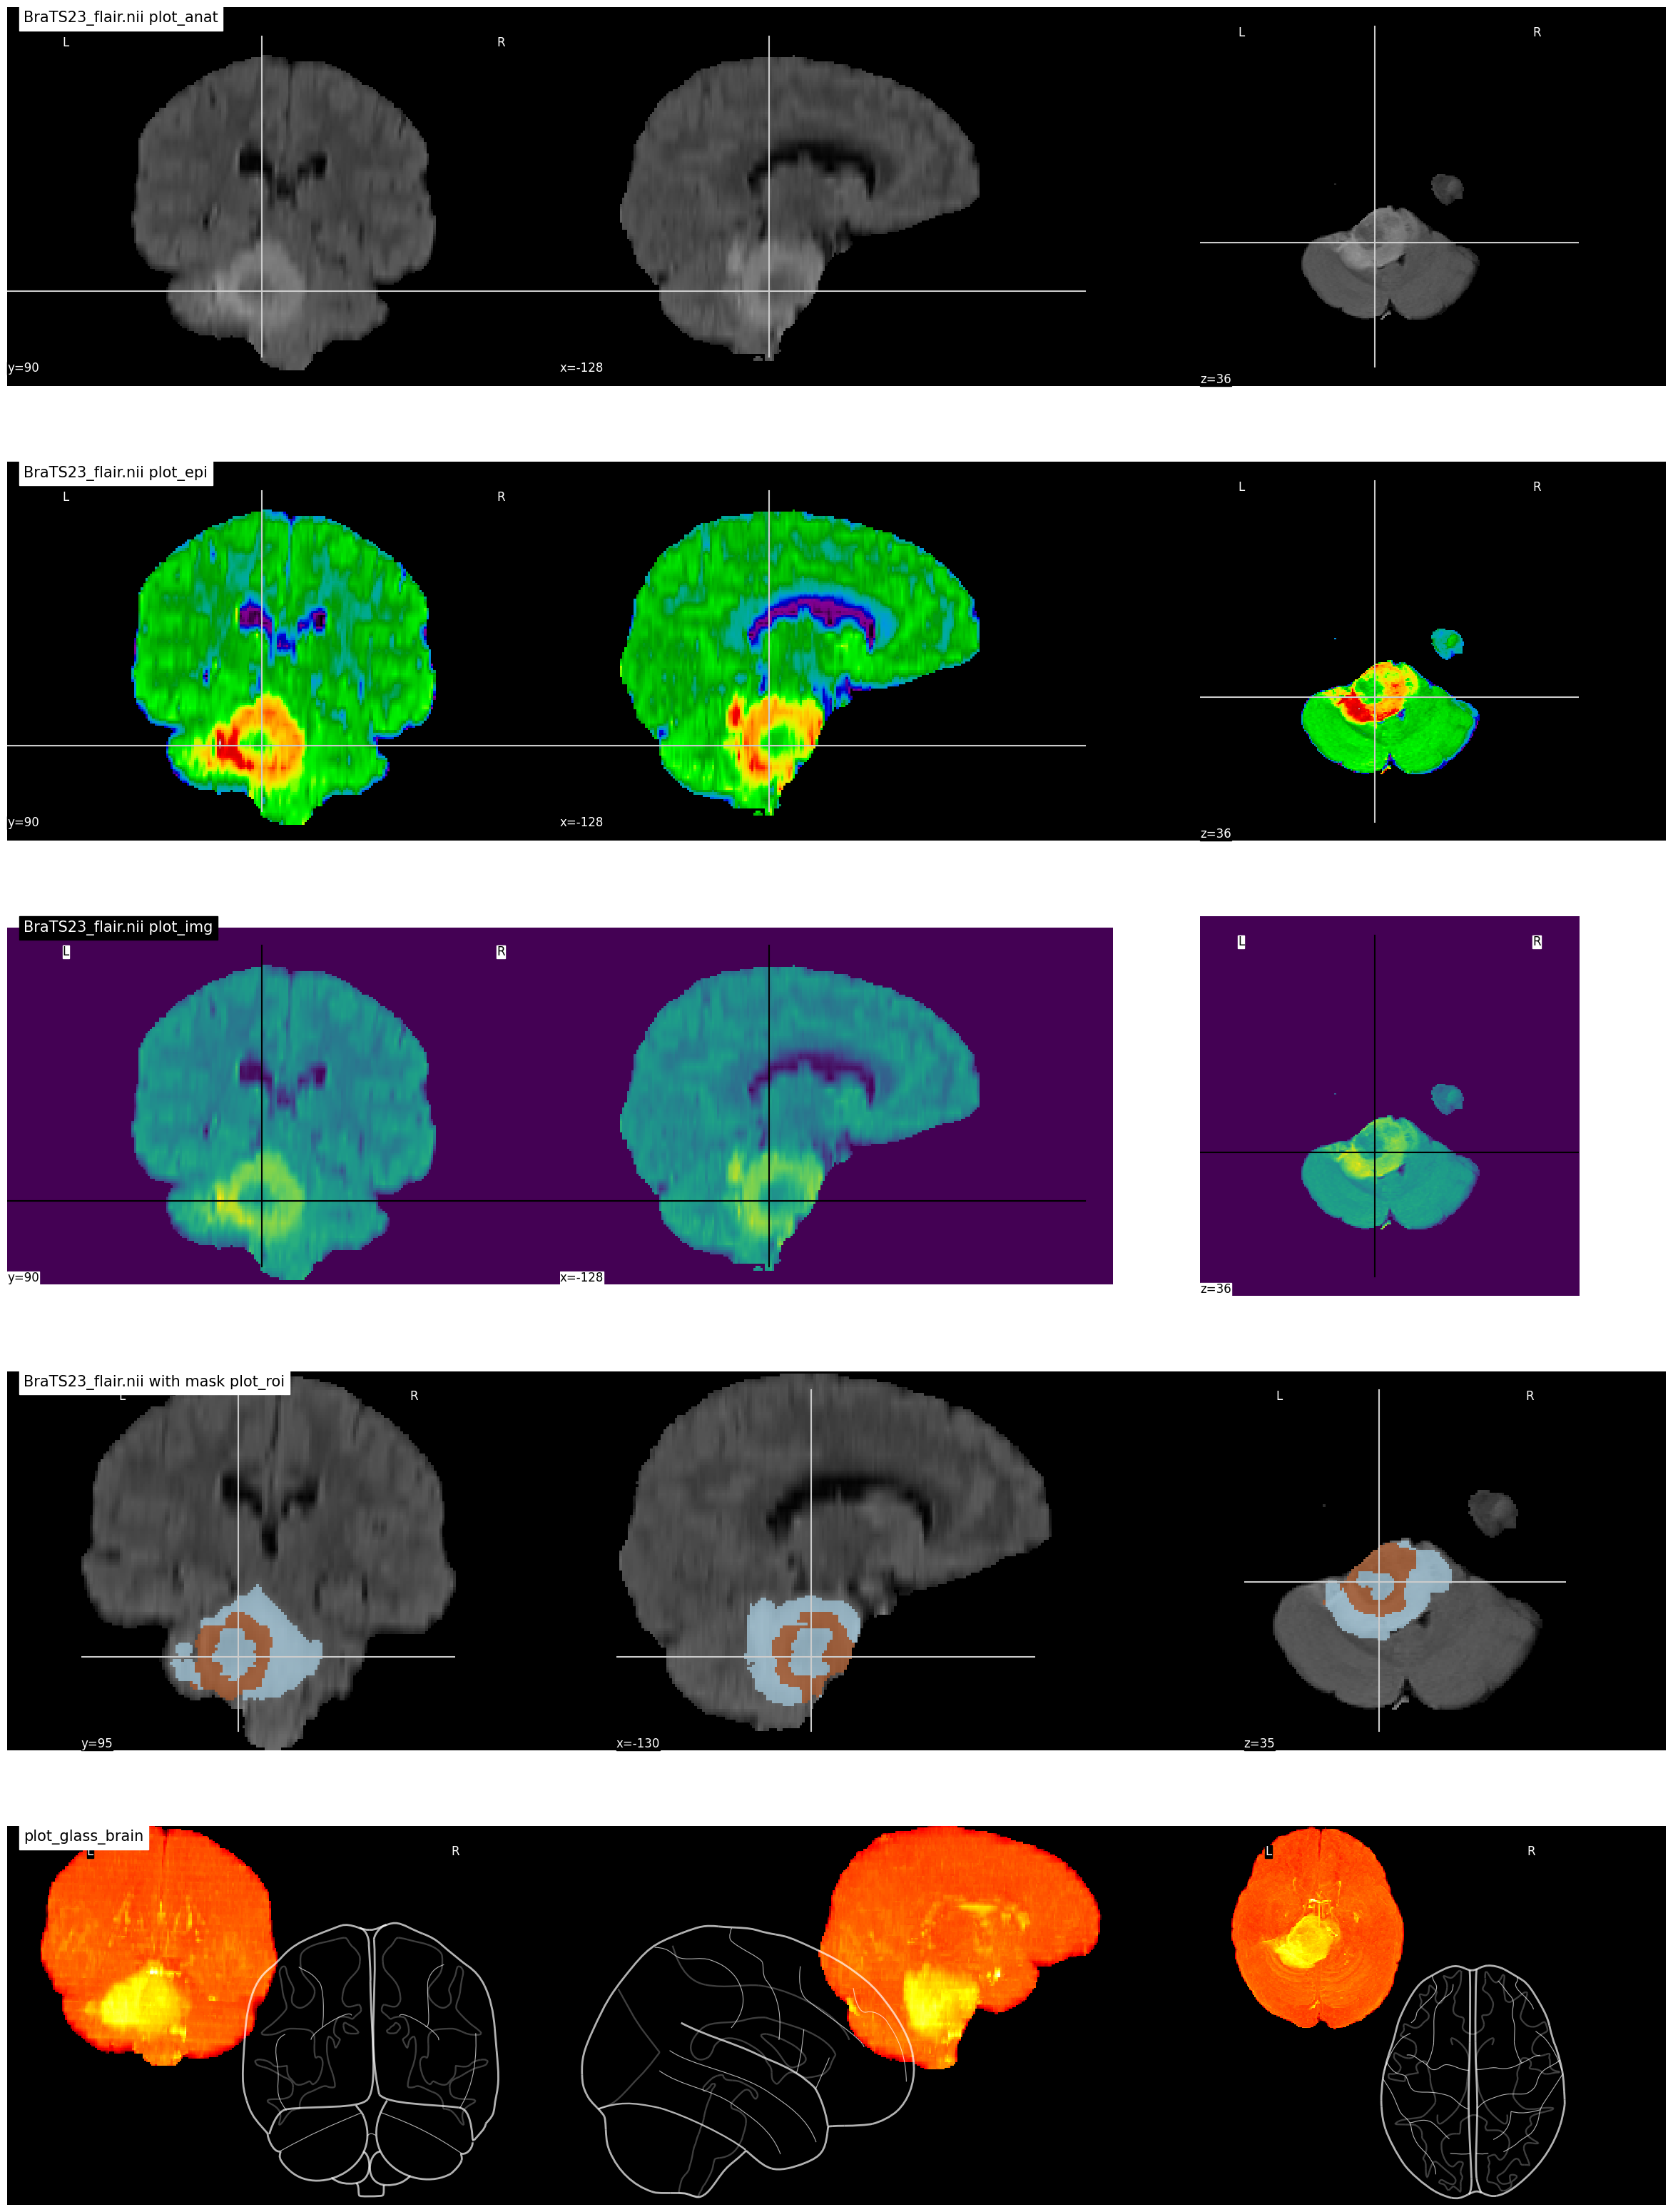

In [ ]:
#Show segments of tumor using different effects
niimg = nl.image.load_img(os.path.join(example_1_path, sorted(example_1_files)[3]))
nimask = nl.image.load_img(os.path.join(example_1_path, sorted(example_1_files)[0]))

fig, axes = plt.subplots(nrows=5, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS23_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS23_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS23_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask,
               title='BraTS23_flair.nii with mask plot_roi',
               bg_img=niimg,
               axes=axes[3], cmap='Paired')

nlplt.plot_glass_brain(
                niimg, title='plot_glass_brain', axes=axes[4],
                black_bg=True)

plt.show()

## 3.0. Models

1. U-Net 2D

### 3.1 U-Net 2D

u-net is convolutional network architecture for fast and precise segmentation of images. Up to now it has outperformed the prior best method (a sliding-window convolutional network) on the ISBI challenge for segmentation of neuronal structures in electron microscopic stacks.


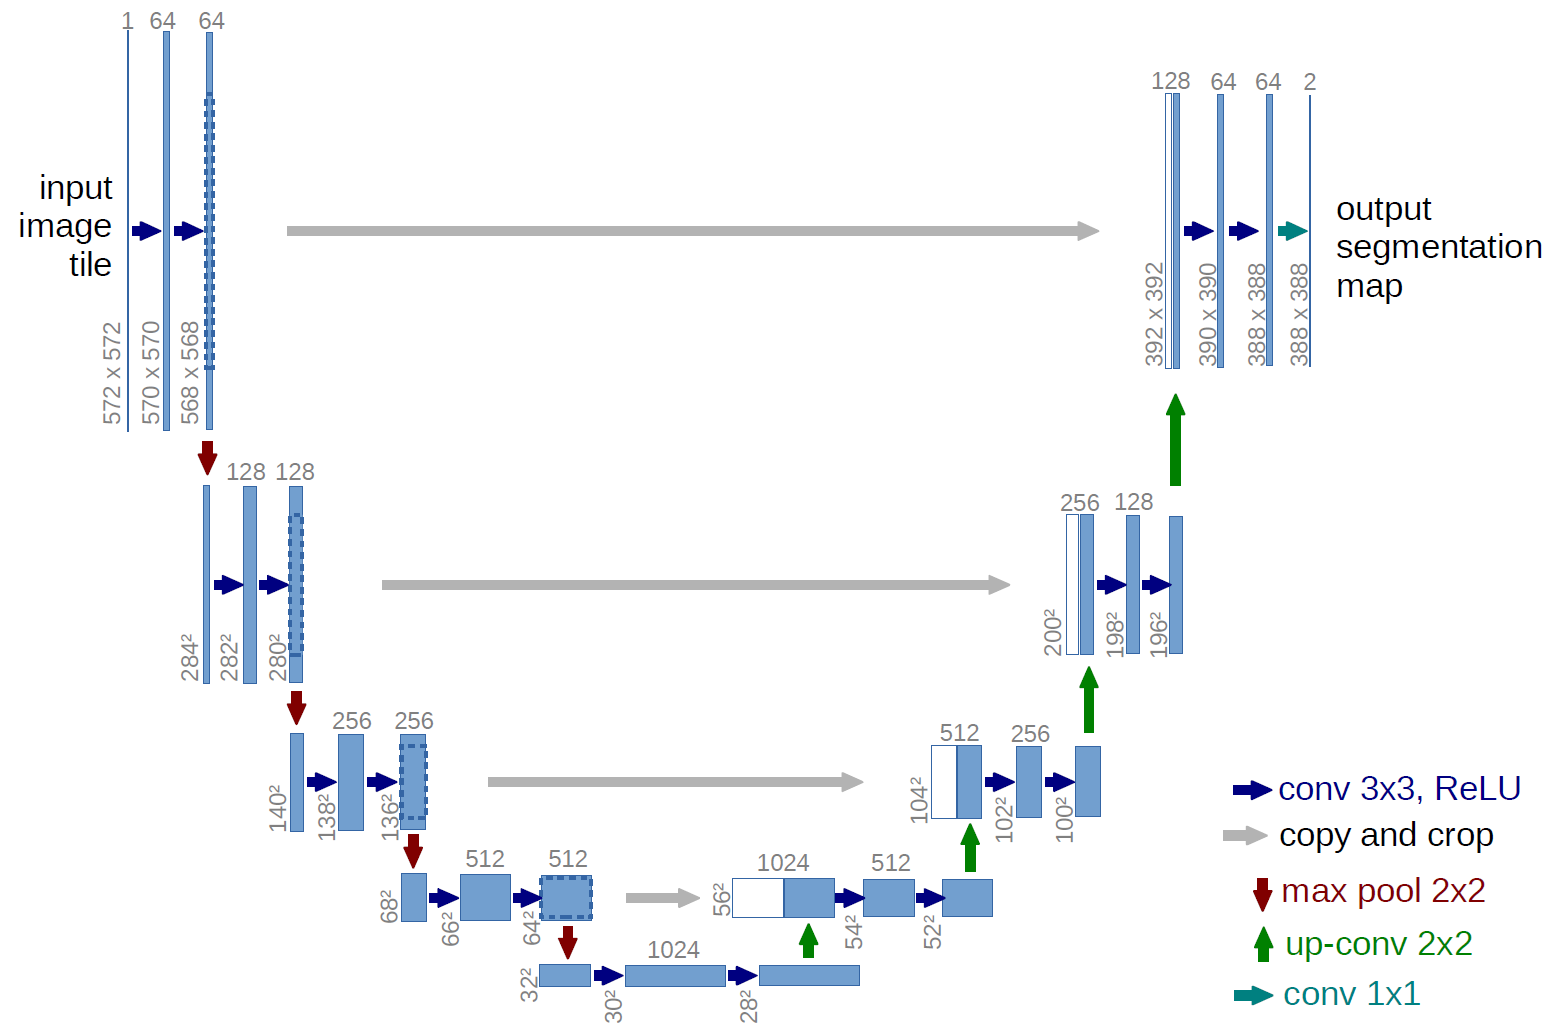

#### 3.1.1 Loss Functions

**Dice coefficient** , which is essentially a measure of overlap between two samples. This measure ranges from 0 to 1 where a Dice coefficient of 1 denotes perfect and complete overlap. The Dice coefficient was originally developed for binary data, and can be calculated as:

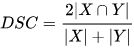

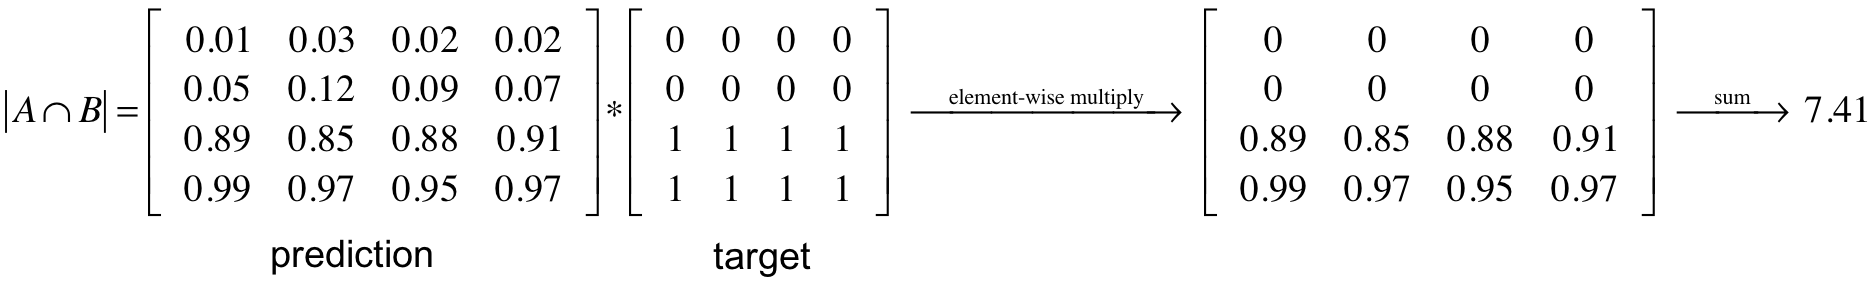

In [ ]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss



# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include

IMG_SIZE=128

In [ ]:
# source https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a

def build_unet(inputs, ker_init, dropout):
    conv1 = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = tf.keras.layers.Dropout(dropout)(conv5)

    up7 = tf.keras.layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = tf.keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = tf.keras.layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = tf.keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = tf.keras.layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = tf.keras.layers.concatenate([conv,up9], axis = 3)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = tf.keras.layers.Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = tf.keras.layers.concatenate([conv1,up], axis = 3)
    conv = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = tf.keras.layers.Conv2D(4, (1,1), activation = 'softmax')(conv)

    return tf.keras.Model(inputs = inputs, outputs = conv10)

input_layer = tf.keras.layers.Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',
                         tf.keras.metrics.MeanIoU(num_classes=4),
                         dice_coef, precision, sensitivity, specificity,
                         dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

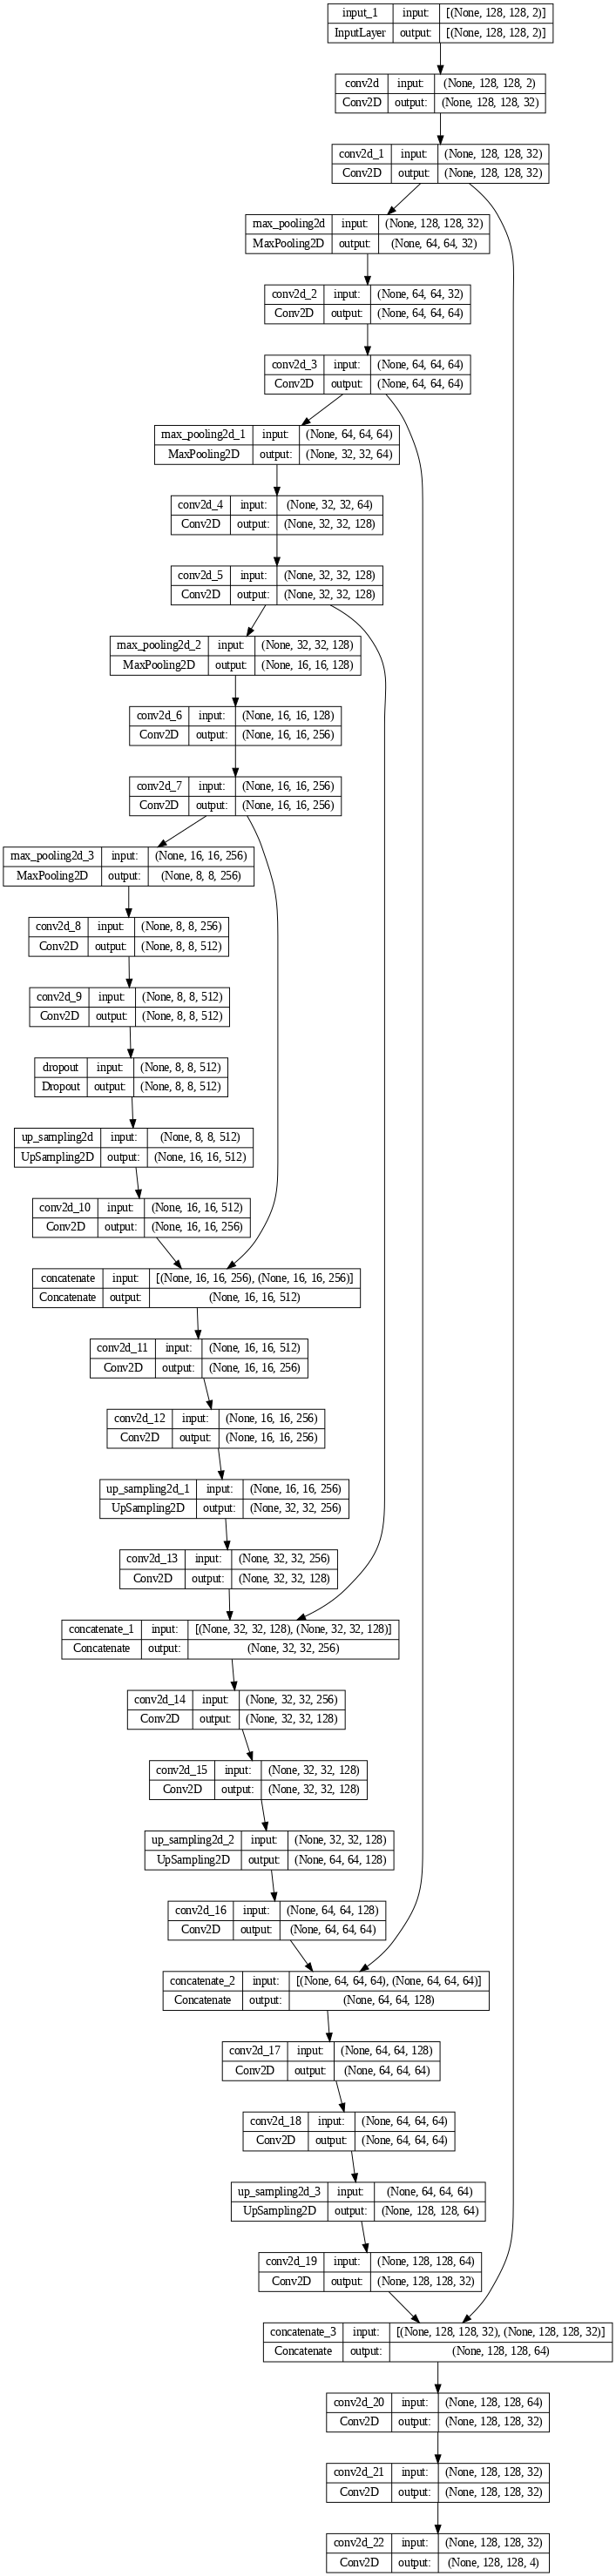

In [ ]:
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

#### 3.1.2 Loading data in 2D form

Loading all data into memory is not a good idea since the data are too big to fit in. So we will create dataGenerators - load data on the fly as explained

In [ ]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(configs.data_dir_path) if f.is_dir()]

In [ ]:
len(train_and_val_directories), train_and_val_directories[0]

(99,
 '/content/Brat23/ASNR-MICCAI-BraTS2023-PED-Challenge-TrainingData/BraTS-PED-00110-000')

In [ ]:
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

In [ ]:
train_and_test_ids = pathListIntoIds(train_and_val_directories);

In [ ]:
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.1)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.10)

In [ ]:
print(len(train_ids), len(val_ids), len(test_ids))

80 10 9


In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(configs.data_dir_path, i)

            data_path = os.path.join(case_path, f'{i}-t2f.nii.gz');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}-t1c.nii.gz');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}-seg.nii.gz');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

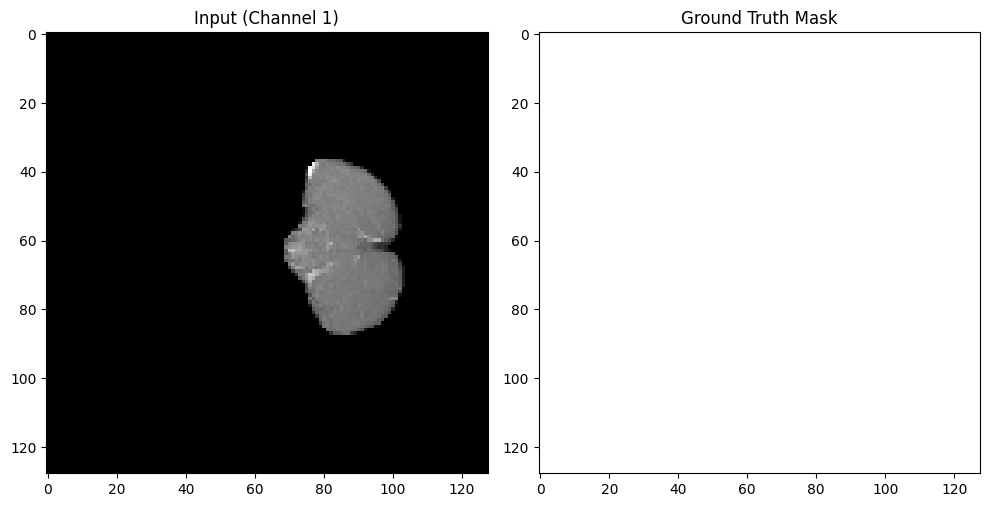

In [ ]:
# Retrieve a batch of data
batch_X, batch_y = training_generator.__getitem__(1)  # Retrieve the first batch (index 0)

# Select an example from the batch (first example, index 0)
example_X = batch_X[0]
example_y = batch_y[0]

# Plot the example
plt.figure(figsize=(10, 5))

# Plot the first channel of input (X)
plt.subplot(1, 2, 1)
plt.imshow(example_X[:, :, 1], cmap='gray')
plt.title('Input (Channel 1)')

# Plot the ground truth mask (y)
plt.subplot(1, 2, 2)
plt.imshow(example_y[:, :, :], cmap='jet')
plt.title('Ground Truth Mask')

plt.tight_layout()
plt.show()

In [ ]:
example_X.shape, example_y.shape

((128, 128, 2), TensorShape([128, 128, 4]))

In [ ]:
np.unique(example_y[example_y!=0.0])

array([0.00390625, 0.01171875, 0.01953125, 0.03515625, 0.04296875,
       0.05078125, 0.05859375, 0.0625    , 0.08203125, 0.10546875,
       0.12890625, 0.13671875, 0.17578125, 0.1875    , 0.21484375,
       0.24609375, 0.25390625, 0.29296875, 0.30078125, 0.3125    ,
       0.31640625, 0.33984375, 0.35546875, 0.38671875, 0.41015625,
       0.4375    , 0.45703125, 0.47265625, 0.52734375, 0.54296875,
       0.5625    , 0.58984375, 0.61328125, 0.64453125, 0.66015625,
       0.68359375, 0.6875    , 0.69921875, 0.70703125, 0.74609375,
       0.75390625, 0.78515625, 0.8125    , 0.82421875, 0.86328125,
       0.87109375, 0.89453125, 0.91796875, 0.9375    , 0.94140625,
       0.94921875, 0.95703125, 0.96484375, 0.98046875, 0.98828125,
       0.99609375, 1.        ], dtype=float32)

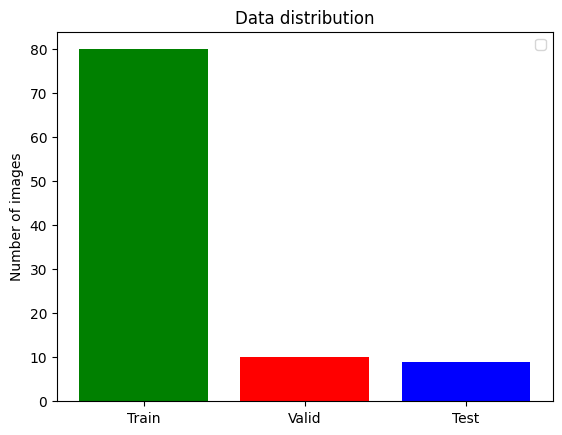

In [ ]:
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()

showDataLayout()

#### 3.1.3 Callbacks

In [ ]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

#### 3.1.4 Training

In [ ]:
K.clear_session()

history =  model.fit(training_generator,
                    epochs=35,
                    steps_per_epoch=len(train_ids),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )
model.save("model_x1_1.h5")

Epoch 1/35
80/80 [==============================] - 119s 1s/step - loss: 0.1565 - accuracy: 0.9784 - mean_io_u: 0.6444 - dice_coef: 0.2550 - precision: 0.9786 - sensitivity: 0.9617 - specificity: 0.9967 - dice_coef_necrotic: 0.0620 - dice_coef_edema: 0.0049 - dice_coef_enhancing: 0.0117 - val_loss: 0.0984 - val_accuracy: 0.9877 - val_mean_io_u: 0.4595 - val_dice_coef: 0.2518 - val_precision: 0.9876 - val_sensitivity: 0.9876 - val_specificity: 0.9959 - val_dice_coef_necrotic: 0.0615 - val_dice_coef_edema: 0.0021 - val_dice_coef_enhancing: 0.0080 - lr: 0.0010
Epoch 2/35
80/80 [==============================] - 85s 1s/step - loss: 0.0608 - accuracy: 0.9913 - mean_io_u: 0.6931 - dice_coef: 0.2580 - precision: 0.9913 - sensitivity: 0.9912 - specificity: 0.9971 - dice_coef_necrotic: 0.0853 - dice_coef_edema: 0.0070 - dice_coef_enhancing: 0.0123 - val_loss: 0.0706 - val_accuracy: 0.9877 - val_mean_io_u: 0.7550 - val_dice_coef: 0.2672 - val_precision: 0.9876 - val_sensitivity: 0.9876 - val_spe

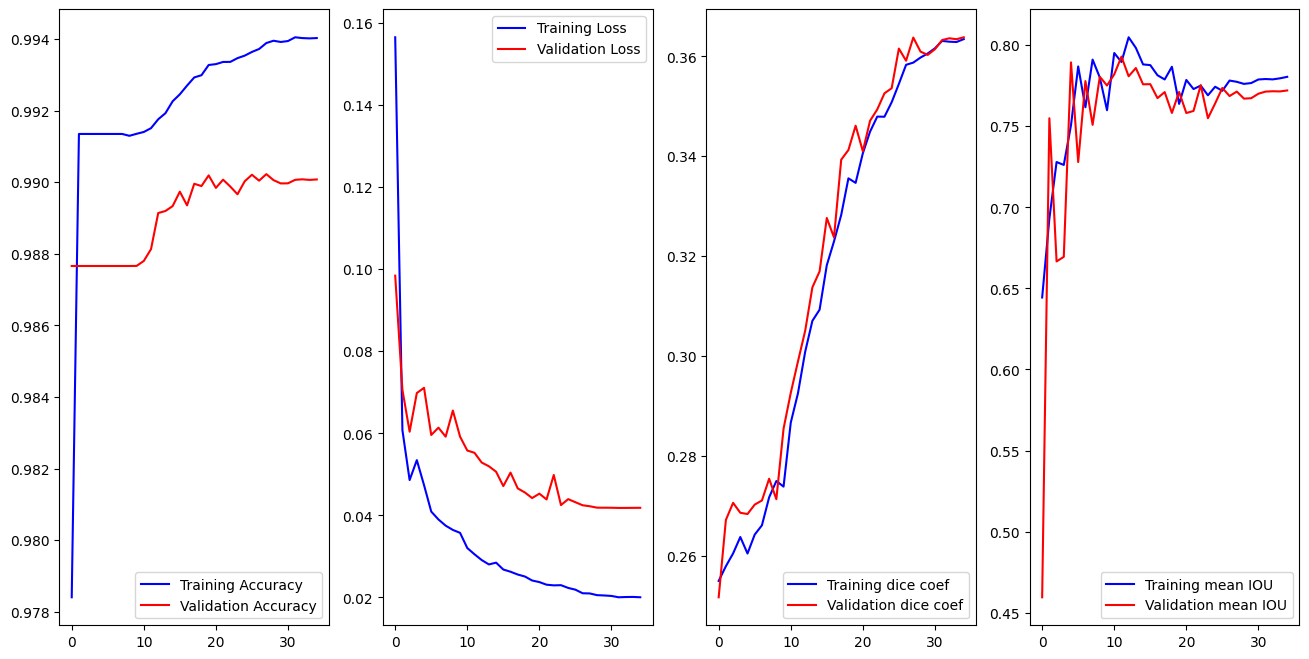

In [ ]:
hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

#### 3.1.5 Prediction examples

In [ ]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))

    vol_path = os.path.join(case_path, f'BraTS-PED-{case}-000-t2f.nii.gz');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS-PED-{case}-000-t1c.nii.gz');
    ce=nib.load(vol_path).get_fdata()

 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()


    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)

In [ ]:
configs.data_dir_path+"/BraTS-PED-{}-000"

'/content/Brat23/ASNR-MICCAI-BraTS2023-PED-Challenge-TrainingData/BraTS-PED-{}-000'

In [ ]:
def showPredictsById(case, start_slice = 60):
    path = os.path.join(configs.data_dir_path, f"BraTS-PED-{case}-000")
    gt = nib.load(os.path.join(path, f'BraTS-PED-{case}-000-seg.nii.gz')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS-PED-{case}-000-t2f.nii.gz')).get_fdata()

    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()


4/4 [==============================] - 4s 323ms/step


<Figure size 1800x5000 with 0 Axes>

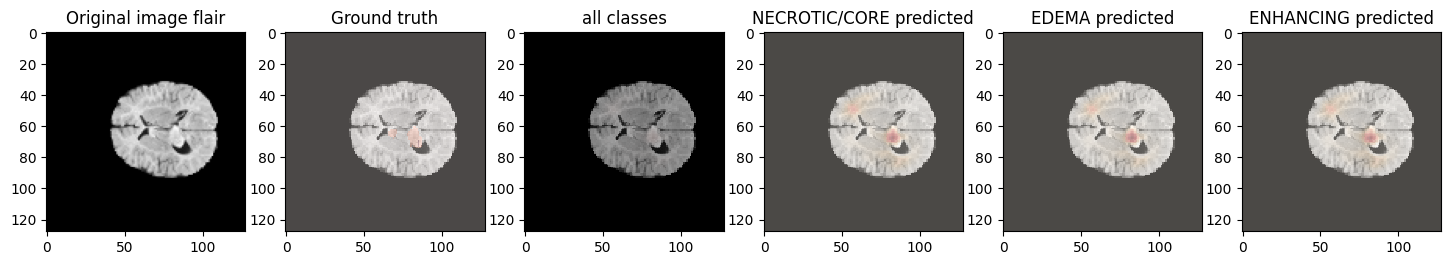

4/4 [==============================] - 0s 64ms/step


<Figure size 1800x5000 with 0 Axes>

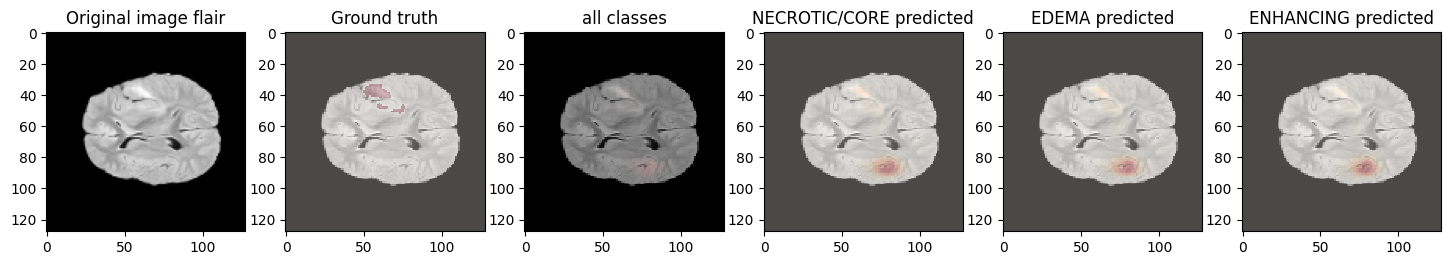

4/4 [==============================] - 0s 49ms/step


<Figure size 1800x5000 with 0 Axes>

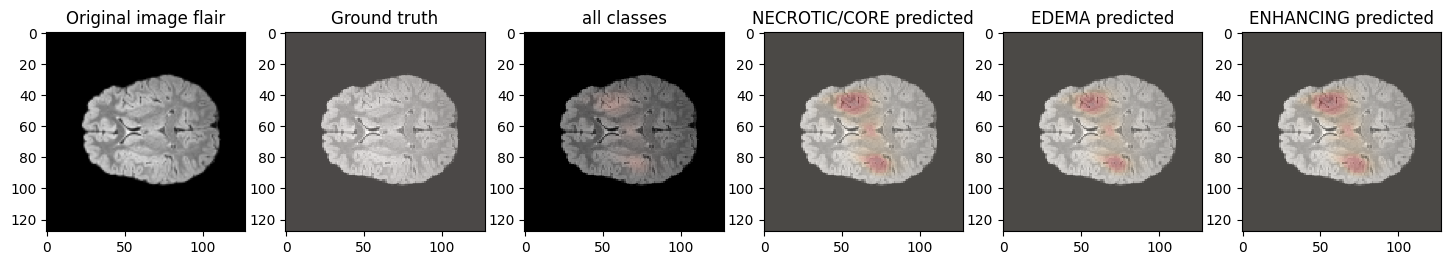

4/4 [==============================] - 0s 46ms/step


<Figure size 1800x5000 with 0 Axes>

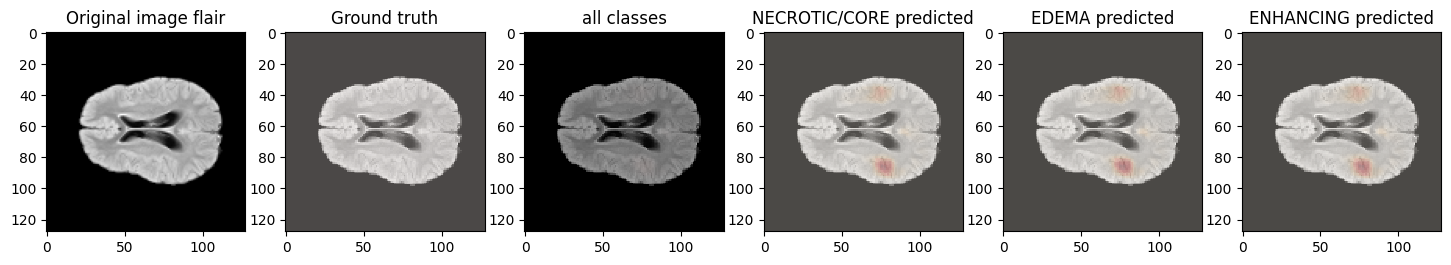

4/4 [==============================] - 0s 47ms/step


<Figure size 1800x5000 with 0 Axes>

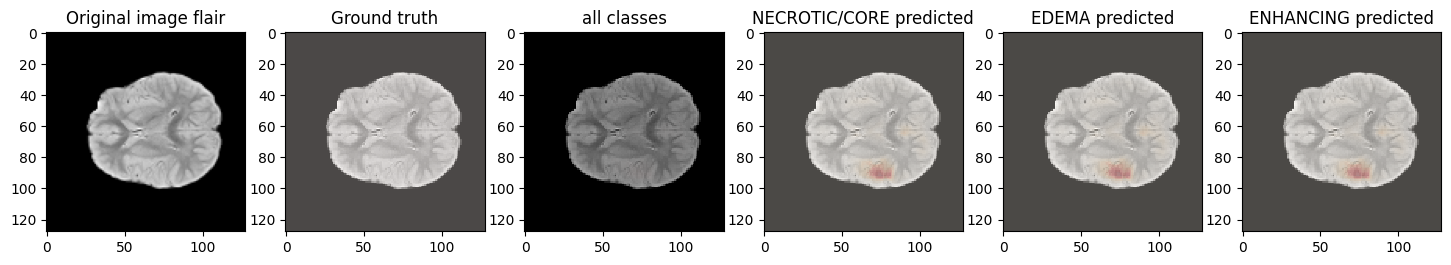

4/4 [==============================] - 0s 59ms/step


<Figure size 1800x5000 with 0 Axes>

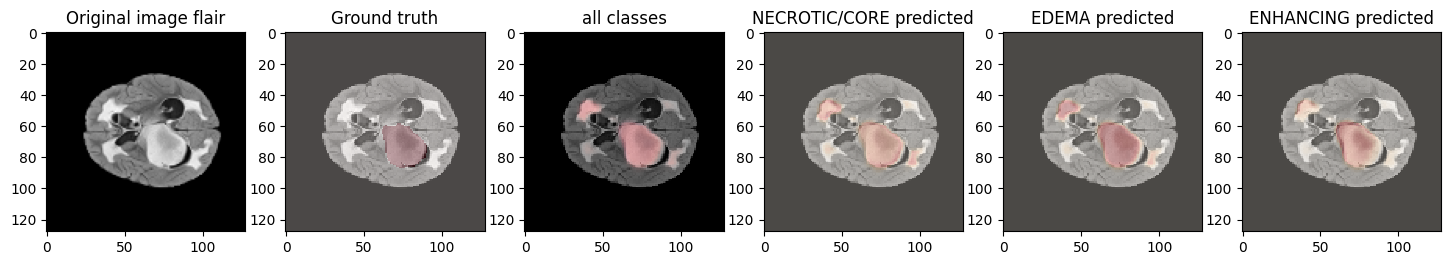

4/4 [==============================] - 0s 66ms/step


<Figure size 1800x5000 with 0 Axes>

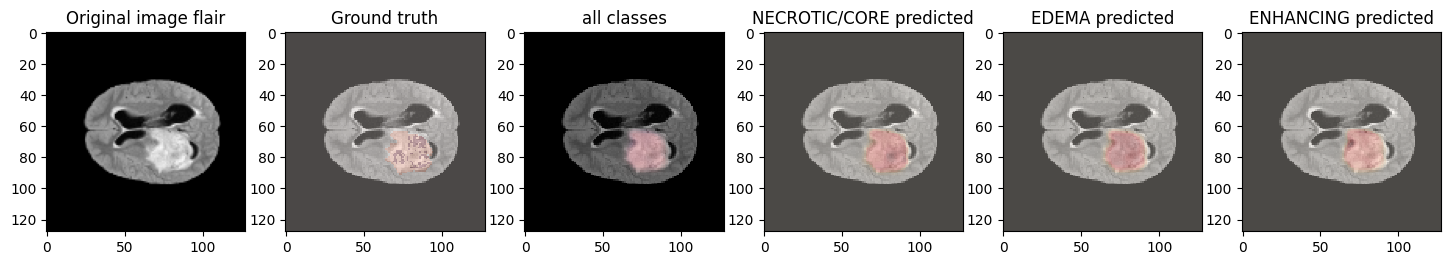

In [ ]:


showPredictsById(case=test_ids[0][-9:-4])
showPredictsById(case=test_ids[1][-9:-4])
showPredictsById(case=test_ids[2][-9:-4])
showPredictsById(case=test_ids[3][-9:-4])
showPredictsById(case=test_ids[4][-9:-4])
showPredictsById(case=test_ids[5][-9:-4])
showPredictsById(case=test_ids[6][-9:-4])


# mask = np.zeros((10,10))
# mask[3:-3, 3:-3] = 1 # white square in black background
# im = mask + np.random.randn(10,10) * 0.01 # random image
# masked = np.ma.masked_where(mask == 0, mask)

# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(im, 'gray', interpolation='none')
# plt.subplot(1,2,2)
# plt.imshow(im, 'gray', interpolation='none')
# plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)
# plt.show()

4/4 [==============================] - 0s 72ms/step


<Figure size 640x480 with 0 Axes>

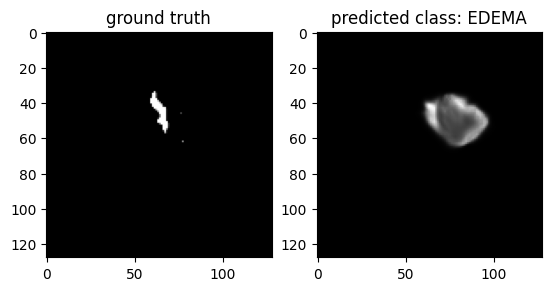

In [ ]:
case = test_ids[8][-9:-4]
path = os.path.join(configs.data_dir_path, f"BraTS-PED-{case}-000")
gt = nib.load(os.path.join(path, f'BraTS-PED-{case}-000-seg.nii.gz')).get_fdata()
p = predictByPath(path,case)


core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'



gt[gt != eval_class] = 1 # use only one class for per class evaluation

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

### 3.2 MONAI EXPS

The following features are included in this tutorial:

1. Transforms for dictionary format data.
2. Define a new transform according to MONAI transform API.
3. Load Nifti image with metadata, load a list of images and stack them.
4. Randomly rotate across each axes for data augmentation.
5. Randomly adjust the intensity for data augmentation.
6. Cache IO and transforms to accelerate training and validation.
7. Swin UNETR model, Dice loss function, Mean Dice metric for brain tumor segmentation task.

#### 3.2.1 Mapping file.json

We'll create a JSON file containing training and validation sets **internal splits**. As the Train dataset is small we'll only create external splits. Run this code for one time and save the json files.

In [ ]:
def create_data_json(directory, data_type):
    _data = []

    # Iterate over directories in the given directory
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            sample = {
                "fold": 1 if data_type == "training" else 0,  # Assign fold 1 for training, 0 for validation
                "image": [],
                "label": ""
            }

            # Find the relevant files for the sample
            files = os.listdir(subdir_path)
            for file in files:
                if file.endswith(".nii.gz"):
                    file_path = os.path.join(subdir_path, file)

                    # Identify the file types and assign them to the corresponding keys
                    if "seg" in file:
                      sample["label"] = file_path
                    else:
                      sample["image"].append(file_path)

            # Add the sample to the data list
            _data.append(sample)

    # For training data, assign different fold value to the last 10 files
    if data_type == "training" and len(_data) >= 10:
        for sample in _data[-10:]:
            sample["fold"] = 2

    # Create a dictionary with the data type as the key
    data_dict = {data_type: _data}

    # Write the data to a JSON file
    json_filename = f"{data_type}_PED_brats23_data.json"
    with open(json_filename, "w") as json_file:
        json.dump(data_dict, json_file, indent=4)


# Directory containing the files
data_directory = configs.data_dir_path

# Create training data JSON
create_data_json(data_directory, "training")

# Directory containing the validation files
validation_directory = configs.data_val_dir_path

# Create validation data JSON
create_data_json(validation_directory, "validation")


#### 3.2.2 Setups
* average meter,
* Train/Val reader,
* checkpoint saver

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)

for internal splits will run the below code

In [ ]:
def datafold_read(datalist, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val

If we were making external splits (maybe in future) then will use the below code, when we'll have validation set labels.

In [ ]:
# # Train and validation file reader from json (external split)
# train_files = []
# validation_files = []
# with open('/content/training_PED_brats23_data.json') as f:
#         json_data = json.load(f)['training']
#         for data in json_data:
#           train_files.append(data)

# with open('/content/validation_PED_brats23_data.json') as f:
#         json_data = json.load(f)['validation']
#         for data in json_data:
#           validation_files.append(data)

In [ ]:
# len(train_files), len(validation_files)

(99, 45)

In [ ]:
def save_checkpoint(model, epoch, filename="model.pt", best_acc=0, dir_add=configs.HOME):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

#### 3.2.3 Setup dataloader

In [ ]:
def get_loader(batch_size, roi, fold):
    # data_dir = data_dir
    datalist_json = '/content/training_PED_brats23_data.json'
    train_files, validation_files = datafold_read(datalist=datalist_json, fold=fold)
    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
            ),
            transforms.RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[roi[0], roi[1], roi[2]],
                random_size=False,
            ),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
    )
    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ]
    )

    train_ds = data.Dataset(data=train_files, transform=train_transform)

    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
    )
    val_ds = data.Dataset(data=validation_files, transform=val_transform)

    val_loader = data.DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
    )

    return train_loader, val_loader

#### 3.2.4 hyper-parameters

If GPU memory is not sufficient, reduce sw_batch_size to 2 or batch_size to 1.

Decrease val_every (validation frequency) to 1 for obtaining more accurate checkpoints.



In [ ]:
# data_dir = "/data/brats2021challenge"
# json_list = "./brats21_folds.json"
roi = (128, 128, 128)
batch_size = 1
sw_batch_size = 1
fold = 2 # 90:10 split
infer_overlap = 0.5
max_epochs = 100
val_every = 10
train_loader, val_loader = get_loader(batch_size, roi, fold)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [ ]:
train_loader, val_loader

(<monai.data.dataloader.DataLoader at 0x786fd9b7c160>,
 <monai.data.dataloader.DataLoader at 0x786fd9b7c2e0>)

In [ ]:
next(iter(train_loader))

{'fold': tensor([1]),
 'image': metatensor([[[[[-4.1985e-02, -4.1985e-02, -4.1985e-02,  ..., -4.1985e-02,
             -4.1985e-02, -4.1985e-02],
            [-4.1985e-02, -4.1985e-02, -4.1985e-02,  ..., -4.1985e-02,
             -4.1985e-02, -4.1985e-02],
            [-4.1985e-02, -4.1985e-02, -4.1985e-02,  ..., -4.1985e-02,
             -4.1985e-02, -4.1985e-02],
            ...,
            [-1.5840e-01, -6.8099e-01, -1.0336e+00,  ..., -4.1985e-02,
             -4.1985e-02, -4.1985e-02],
            [-4.5964e-01, -8.2829e-01, -8.5229e-01,  ..., -4.1985e-02,
             -4.1985e-02, -4.1985e-02],
            [-7.2570e-01, -1.0694e+00, -1.0757e+00,  ..., -4.1985e-02,
             -4.1985e-02, -4.1985e-02]],
 
           [[-4.1985e-02, -4.1985e-02, -4.1985e-02,  ..., -4.1985e-02,
             -4.1985e-02, -4.1985e-02],
            [-4.1985e-02, -4.1985e-02, -4.1985e-02,  ..., -4.1985e-02,
             -4.1985e-02, -4.1985e-02],
            [-4.1985e-02, -4.1985e-02, -4.1985e-02,  ...,

In [ ]:
next(iter(val_loader))

{'fold': tensor([2]),
 'image': metatensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]],
 
           [[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]],
 
           [[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]],
 
           ...,
 
           [[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
       

#### 3.2.5 Swin UNETR
We'll first use [Swin UNETR](https://arxiv.org/pdf/2201.01266.pdf) model, For more details please visit the [MONAI tutorial notebooks](https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/swin_unetr_brats21_segmentation_3d.ipynb) from which this entire notebook has been created.

The architecture of Swin UNETR is demonstrated below


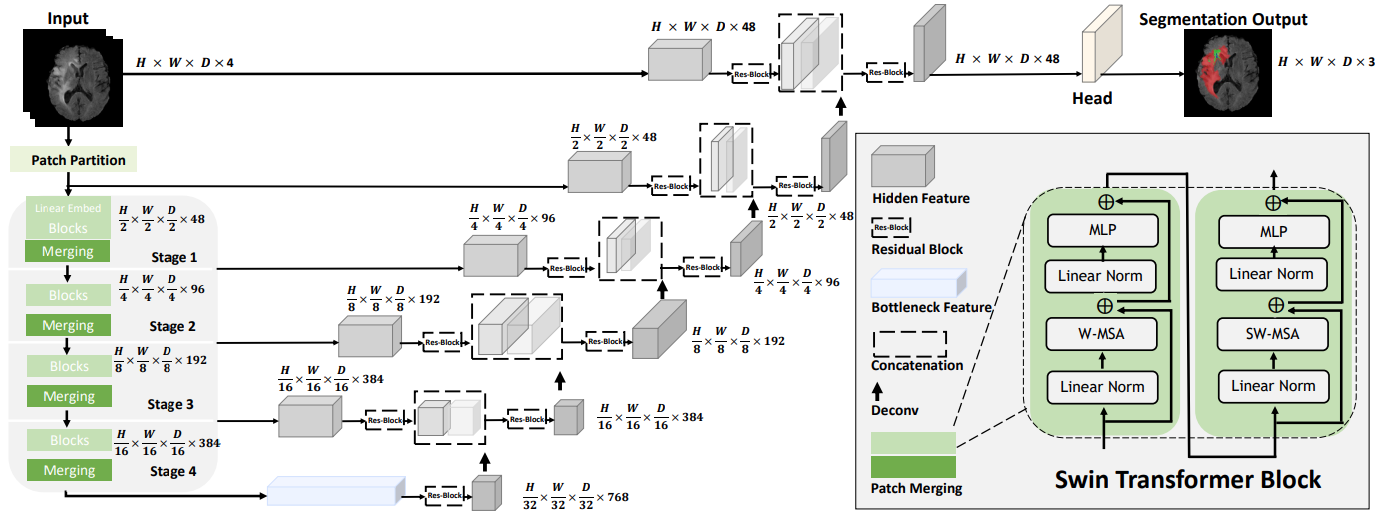


The inputs to [Swin UNETR](https://arxiv.org/pdf/2201.01266.pdf) are 3D multi-modal MRI images with 4 channels. The patch partition block creates non-overlapping patches of the input data and projects them into embedding tokens with a resolution of 128x128x128. The projected tokens are then encoded by using a 3D Swin Transformer in which the self-attention is computed within local windows. The interaction between different windows is obtained by using 3D window shifting as illustrated below.


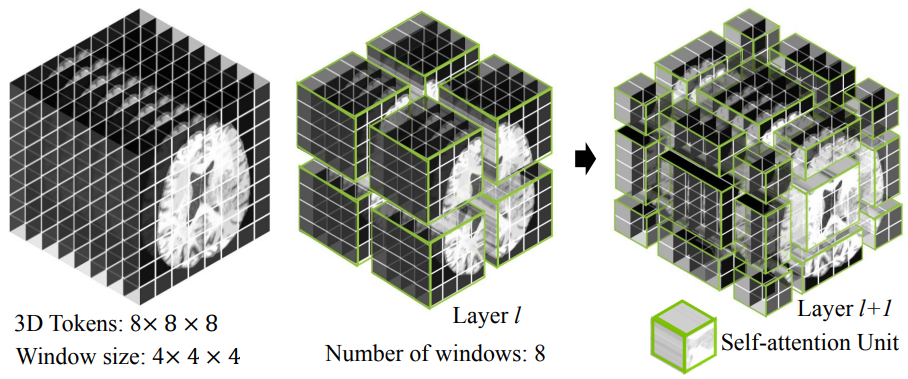

The transformer-based encoder is connected to a CNN-decoder via skip connection at multiple resolutions. The segmentation output consists of 3 output channels corresponding to ET, WT, and TC sub-regions and is computed by using a 1x1x1 convolutional layer followed by Sigmoid activation function.

##### Modelling

In this section, we create Swin UNETR model for the 3-class brain tumor semantic segmentation. We use a feature size of 48. We also use gradient checkpointing (use_checkpoint) for more memory-efficient training. However, use_checkpoint for faster training if enough GPU memory is available.

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=roi,
    in_channels=4,
    out_channels=3,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

##### Optimizer and loss function

In [ ]:
torch.backends.cudnn.benchmark = True
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
dice_acc = DiceMetric(include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True)
model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

##### Train and Val Epoch

In [ ]:
def train_epoch(model, loader, optimizer, epoch, loss_func):
    model.train()
    start_time = time.time()
    run_loss = AverageMeter()
    for idx, batch_data in enumerate(loader):
        data, target = batch_data["image"].to(device), batch_data["label"].to(device)
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()
        run_loss.update(loss.item(), n=batch_size)
        print(
            "Epoch {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
            "loss: {:.4f}".format(run_loss.avg),
            "time {:.2f}s".format(time.time() - start_time),
        )
        start_time = time.time()
    return run_loss.avg


def val_epoch(
    model,
    loader,
    epoch,
    acc_func,
    model_inferer=None,
    post_sigmoid=None,
    post_pred=None,
):
    model.eval()
    start_time = time.time()
    run_acc = AverageMeter()

    with torch.no_grad():
        for idx, batch_data in enumerate(loader):
            data, target = batch_data["image"].to(device), batch_data["label"].to(device)
            logits = model_inferer(data)
            val_labels_list = decollate_batch(target)
            val_outputs_list = decollate_batch(logits)
            val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            acc_func.reset()
            acc_func(y_pred=val_output_convert, y=val_labels_list)
            acc, not_nans = acc_func.aggregate()
            run_acc.update(acc.cpu().numpy(), n=not_nans.cpu().numpy())
            dice_tc = run_acc.avg[0]
            dice_wt = run_acc.avg[1]
            dice_et = run_acc.avg[2]
            print(
                "Val {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", time {:.2f}s".format(time.time() - start_time),
            )
            start_time = time.time()

    return run_acc.avg

##### Define Trainer

In [ ]:
def trainer(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_func,
    acc_func,
    scheduler,
    model_inferer=None,
    start_epoch=0,
    post_sigmoid=None,
    post_pred=None,
):
    val_acc_max = 0.0
    dices_tc = []
    dices_wt = []
    dices_et = []
    dices_avg = []
    loss_epochs = []
    trains_epoch = []
    for epoch in range(start_epoch, max_epochs):
        print(time.ctime(), "Epoch:", epoch)
        epoch_time = time.time()
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            epoch=epoch,
            loss_func=loss_func,
        )
        print(
            "Final training  {}/{}".format(epoch, max_epochs - 1),
            "loss: {:.4f}".format(train_loss),
            "time {:.2f}s".format(time.time() - epoch_time),
        )

        if (epoch + 1) % val_every == 0 or epoch == 0:
            loss_epochs.append(train_loss)
            trains_epoch.append(int(epoch))
            epoch_time = time.time()
            val_acc = val_epoch(
                model,
                val_loader,
                epoch=epoch,
                acc_func=acc_func,
                model_inferer=model_inferer,
                post_sigmoid=post_sigmoid,
                post_pred=post_pred,
            )
            dice_tc = val_acc[0]
            dice_wt = val_acc[1]
            dice_et = val_acc[2]
            val_avg_acc = np.mean(val_acc)
            print(
                "Final validation stats {}/{}".format(epoch, max_epochs - 1),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", Dice_Avg:",
                val_avg_acc,
                ", time {:.2f}s".format(time.time() - epoch_time),
            )
            dices_tc.append(dice_tc)
            dices_wt.append(dice_wt)
            dices_et.append(dice_et)
            dices_avg.append(val_avg_acc)
            if val_avg_acc > val_acc_max:
                print("new best ({:.6f} --> {:.6f}). ".format(val_acc_max, val_avg_acc))
                val_acc_max = val_avg_acc
                save_checkpoint(
                    model,
                    epoch,
                    best_acc=val_acc_max,
                )
            scheduler.step()
    print("Training Finished !, Best Accuracy: ", val_acc_max)
    return (
        val_acc_max,
        dices_tc,
        dices_wt,
        dices_et,
        dices_avg,
        loss_epochs,
        trains_epoch,
    )

##### Execute training

In [ ]:
start_epoch = 0

(
    val_acc_max,
    dices_tc,
    dices_wt,
    dices_et,
    dices_avg,
    loss_epochs,
    trains_epoch,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=dice_loss,
    acc_func=dice_acc,
    scheduler=scheduler,
    model_inferer=model_inferer,
    start_epoch=start_epoch,
    post_sigmoid=post_sigmoid,
    post_pred=post_pred,
)

Thu Jul 13 03:43:46 2023 Epoch: 0
Epoch 0/100 0/89 loss: 0.9995 time 129.96s
Epoch 0/100 1/89 loss: 0.9730 time 3.18s
Epoch 0/100 2/89 loss: 0.9776 time 3.16s
Epoch 0/100 3/89 loss: 0.9811 time 3.18s
Epoch 0/100 4/89 loss: 0.9839 time 3.20s
Epoch 0/100 5/89 loss: 0.9835 time 3.21s
Epoch 0/100 6/89 loss: 0.9834 time 3.24s
Epoch 0/100 7/89 loss: 0.9831 time 3.23s
Epoch 0/100 8/89 loss: 0.9806 time 3.23s
Epoch 0/100 9/89 loss: 0.9785 time 3.28s
Epoch 0/100 10/89 loss: 0.9797 time 3.26s
Epoch 0/100 11/89 loss: 0.9791 time 3.28s
Epoch 0/100 12/89 loss: 0.9761 time 3.29s
Epoch 0/100 13/89 loss: 0.9774 time 3.29s
Epoch 0/100 14/89 loss: 0.9770 time 3.24s
Epoch 0/100 15/89 loss: 0.9758 time 3.24s
Epoch 0/100 16/89 loss: 0.9747 time 3.24s
Epoch 0/100 17/89 loss: 0.9728 time 3.22s
Epoch 0/100 18/89 loss: 0.9731 time 3.22s
Epoch 0/100 19/89 loss: 0.9716 time 3.21s
Epoch 0/100 20/89 loss: 0.9717 time 3.21s
Epoch 0/100 21/89 loss: 0.9729 time 3.19s
Epoch 0/100 22/89 loss: 0.9738 time 3.21s
Epoch 0/

None of the inputs have requires_grad=True. Gradients will be None
invalid value encountered in true_divide


Val 0/100 0/10 , dice_tc: 0.05507624 , dice_wt: 0.095833994 , dice_et: 0.0 , time 20.28s
Val 0/100 1/10 , dice_tc: 0.03455411 , dice_wt: 0.05578843 , dice_et: 0.0 , time 15.49s
Val 0/100 2/10 , dice_tc: 0.03152439 , dice_wt: 0.047300413 , dice_et: 0.0 , time 15.49s
Val 0/100 3/10 , dice_tc: 0.052903987 , dice_wt: 0.07521396 , dice_et: 0.0 , time 15.53s
Val 0/100 4/10 , dice_tc: 0.07402761 , dice_wt: 0.11505487 , dice_et: 0.0 , time 15.53s
Val 0/100 5/10 , dice_tc: 0.06980388 , dice_wt: 0.10509822 , dice_et: 0.0 , time 15.53s
Val 0/100 6/10 , dice_tc: 0.088385716 , dice_wt: 0.13423972 , dice_et: 0.0 , time 15.53s
Val 0/100 7/10 , dice_tc: 0.087047875 , dice_wt: 0.12824671 , dice_et: 0.0 , time 15.54s
Val 0/100 8/10 , dice_tc: 0.07896182 , dice_wt: 0.13005239 , dice_et: 0.0 , time 15.55s
Val 0/100 9/10 , dice_tc: 0.074517675 , dice_wt: 0.120833516 , dice_et: 0.0 , time 15.54s
Final validation stats 0/99 , dice_tc: 0.074517675 , dice_wt: 0.120833516 , dice_et: 0.0 , Dice_Avg: 0.06511706 ,

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()